# PyFina

## Object

In [20]:
from __future__ import annotations
import logging
import math
import os
import struct

from typing import Literal

import numpy as np

logging.basicConfig()
pyfina_logger = logging.getLogger(__name__)


def trim(feed_id: int, data_dir: str, limit: int = 100) -> None:
    """
    checks and removes anomalies (values above a threshold limit, eg 100)
    feed_id: feed number
    data_dir: feed path (eg /var/opt/emoncms/phpfina)
    limit: threshold we don't want to exceed
    """
    meta = getMeta(feed_id, data_dir)
    if not meta:
        return
    pos = 0
    i = 0
    nbn = 0
    with open(f"{data_dir}/{feed_id}.dat", "rb+") as ts:
        while pos <= meta["npoints"]:
            ts.seek(pos * 4, 0)
            hexa = ts.read(4)
            aa = bytearray(hexa)
            if len(aa) == 4:
                value = struct.unpack("<f", aa)[0]
                if math.isnan(value):
                    nbn += 1
                elif value > limit:
                    message = f"anomaly detected at {pos} : {value}"
                    pyfina_logger.debug(message)
                    i += 1
                    nv = struct.pack("<f", float("nan"))
                    try:
                        ts.seek(pos * 4, 0)
                        ts.write(nv)
                    except Exception as e:
                        pyfina_logger.error(e)
                    finally:
                        pyfina_logger.debug("4 bytes written")
            pos += 1
        message = f"{i} anomaly(ies)"
        pyfina_logger.debug(message)
        message = f"{nbn} nan"
        pyfina_logger.debug(message)


def getMeta(feed_id: int, data_dir: str) -> Literal[False] | dict[str, int]:
    """
    decoding the .meta file
    feed_id (4 bytes, Unsigned integer)
    npoints (4 bytes, Unsigned integer, Legacy : use instead filesize//4 )
    interval (4 bytes, Unsigned integer)
    start_time (4 bytes, Unsigned integer)
    """
    with open(f"{data_dir}/{feed_id}.meta", "rb") as f:
        f.seek(8, 0)
        hexa = f.read(8)
        aa = bytearray(hexa)
        if len(aa) == 8:
            decoded = struct.unpack("<2I", aa)
        else:
            pyfina_logger.error("corrupted meta - aborting")
            return False
    meta = {
        "interval": decoded[0],
        "start_time": decoded[1],
        "npoints": os.path.getsize(f"{data_dir}/{feed_id}.dat") // 4,
    }
    return meta

class PyFina(np.ndarray):
    """pyfina class."""
    start: int | None = None
    step: int | None = None
    nb_nan: int | None = None
    first_non_nan_value: float | None = None
    first_non_nan_index: int | None = None
    starting_by_nan : bool | None = None

    def __new__(
        cls,
        feed_id: int,
        data_dir: str,
        start: int,
        step: int,
        npts: int,
        remove_nan: bool = True,
    ):
        meta = getMeta(feed_id, data_dir)
        if not meta:
            return None
        # decoding and sampling the .dat file
        # values are 32 bit floats, stored on 4 bytes
        # to estimate value(time), position in the dat file is calculated as follow :
        # pos = (time - meta["start_time"]) // meta["interval"]
        # Nota : if remove_nan is True and a NAN is detected, the algorithm takes previous value
        obj = super().__new__(cls, shape=(npts,))
        #obj = np.zeros(npts).view(cls)
        pyfina_logger.debug(obj)
        raw_obj = np.empty(npts)

        end = start + (npts - 1) * step
        time = start
        i = 0
        nb_nan = 0
        with open(f"{data_dir}/{feed_id}.dat", "rb") as ts:
            while time < end:
                time = start + step * i
                pos = (time - meta["start_time"]) // meta["interval"]
                if 0 <= pos < meta["npoints"]:
                    try:
                        # message = f"trying to find point {i} going to index {pos}"
                        # pyfina_logger.debug(message)
                        ts.seek(pos * 4, 0)
                        hexa = ts.read(4)
                        aa = bytearray(hexa)
                    except Exception as e:
                        message = f"error during file operation {e}"
                        pyfina_logger.error(message)
                    else:
                        if len(aa) == 4:
                            value = struct.unpack("<f", aa)[0]
                            obj[i] = value
                            raw_obj[i] = value
                            if remove_nan and np.isnan(value):
                                nb_nan += 1
                                obj[i] = obj[i - 1]
                        else:
                            message = f"unpacking problem {i} len is {len(aa)} position is {pos}"
                            pyfina_logger.error(message)
                i += 1
        first_non_nan_value = -1
        first_non_nan_index = -1
        starting_by_nan = np.isnan(raw_obj[0])
        if nb_nan < npts:
            finiteness_obj = np.isfinite(raw_obj)
            if finiteness_obj.sum() > 0:
                first_non_nan_index = np.where(finiteness_obj)[0][0]
                first_non_nan_value = raw_obj[finiteness_obj][0]
                if starting_by_nan and remove_nan:
                    obj[:first_non_nan_index] = (
                        np.ones(first_non_nan_index) * first_non_nan_value
                    )
        # storing the "signature" of the "sampled" feed
        obj.start = start
        obj.step = step
        obj.nb_nan = nb_nan
        obj.first_non_nan_value = first_non_nan_value
        obj.first_non_nan_index = first_non_nan_index
        obj.starting_by_nan = starting_by_nan
        return obj

    def timescale(self):
        """
        return the time scale of the feed as a numpy array
        """
        return np.arange(0, self.step * self.shape[0], self.step)

## Test

### Imports

In [ ]:
import datetime
import os
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from multigraph import check_starting_nan

### Test 1

{'interval': 10, 'start_time': 1575981140, 'npoints': 4551863}
température extérieure : 38 nan in the feed


C:\Users\mexse\AppData\Local\Temp\ipykernel_42592\1106623605.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utcstart = datetime.datetime.utcfromtimestamp(start)


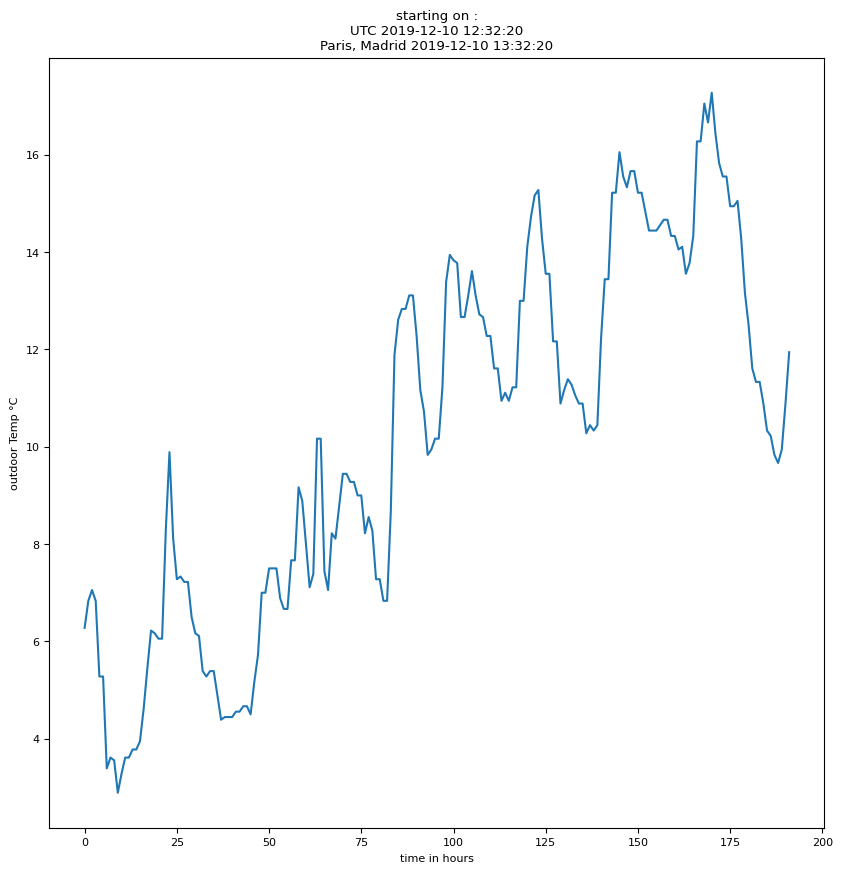

In [15]:
FEED_NB = 1
DATA_DIR = os.path.join(
    os.path.abspath(os.getcwd()),
    # "tests",
    "datas"
)
meta = getMeta(FEED_NB, DATA_DIR)
print(meta)
STEP = 3600
start = meta["start_time"]
length = meta["npoints"] * meta["interval"]
WINDOW = min(8 * 24 * 3600, length)

nbpts = WINDOW // STEP
temp_ext = PyFina(FEED_NB, DATA_DIR, start, STEP, nbpts)

check_starting_nan("température extérieure", temp_ext)

localstart = datetime.datetime.fromtimestamp(start)
utcstart = datetime.datetime.utcfromtimestamp(start)
title = f"starting on :\nUTC {utcstart}\n{time.tzname[0]} {localstart}"
figure = plt.figure(figsize = (10, 10))
matplotlib.rc('font', size=8)
plt.subplot(111)
plt.title(title)
plt.ylabel("outdoor Temp °C")
plt.xlabel("time in hours")
plt.plot(temp_ext)
figure.savefig(f"feed_{FEED_NB}.png")
plt.show()


### Test 2: empty array

{'interval': 1, 'start_time': 1538492746, 'npoints': 5011599}
température extérieure : 0 nan in the feed
first non nan value -1 at index -1


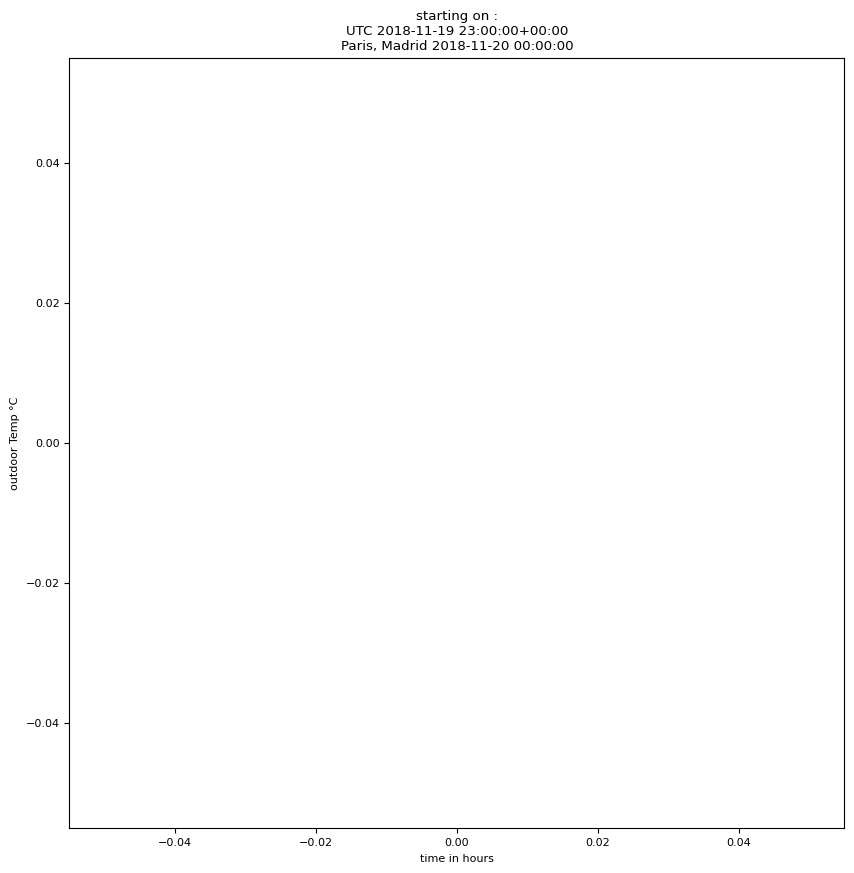

In [116]:
FEED_NB = 2

meta = getMeta(FEED_NB, DATA_DIR)
print(meta)
STEP = 1
start = int(1542637800 + (8 * 3600) + (3600 / 2)) # 1542634200, 1542637800 1727276746
localstart = datetime.datetime.fromtimestamp(start)
utcstart = datetime.datetime.fromtimestamp(start, datetime.timezone.utc)
length = meta["npoints"] * meta["interval"]
WINDOW = min(24 * 3600, length)

nbpts = WINDOW // STEP
temp_ext = PyFina(FEED_NB, DATA_DIR, start, STEP, nbpts, remove_nan=False)

check_starting_nan("température extérieure", temp_ext)

localstart = datetime.datetime.fromtimestamp(start)
utcstart = datetime.datetime.fromtimestamp(start, datetime.timezone.utc)
title = f"starting on :\nUTC {utcstart}\n{time.tzname[0]} {localstart}"
figure = plt.figure(figsize = (10, 10))
matplotlib.rc('font', size=8)
plt.subplot(111)
plt.title(title)
plt.ylabel("outdoor Temp °C")
plt.xlabel("time in hours")
plt.plot(temp_ext)
figure.savefig(f"feed_{FEED_NB}.png")
plt.show()

### Test 3: Scan file

Feed Id: 2 file start at 2018-10-02 17:05:46
meta: {'interval': 1, 'start_time': 1538492746, 'npoints': 5011599}
Analysed 730 Days in 14.683884200057946s -- IO File Reads = 730
Global stats: 


,time,perf,lines,nb_finite,nb_nan,nb_valid,nb_inf
count,7.300000e+02,730.000000,730.0,730.000000,730.000000,730.000000,730.0
mean,1.569986e+09,8.551079,86400.0,11650.294521,74749.705479,11648.456164,0.0
std,1.821978e+07,3.676113,0.0,3299.002040,3299.002040,3298.818659,0.0
min,1.538493e+09,0.067309,86400.0,0.000000,50604.000000,0.000000,0.0
25%,1.554239e+09,5.635861,86400.0,11979.000000,74421.000000,11977.000000,0.0
50%,1.569986e+09,8.664011,86400.0,11979.000000,74421.000000,11977.000000,0.0
75%,1.585732e+09,11.666156,86400.0,11979.000000,74421.000000,11977.000000,0.0
max,1.601478e+09,14.679449,86400.0,35796.000000,86400.000000,35796.000000,0.0


,time,perf,lines,nb_finite,nb_nan,nb_valid,nb_inf
index,,,,,,,
2018-10-02 15:05:46,1538492746,0.067309,86400,18354,68046,18354,0
2018-10-03 15:05:46,1538579146,0.128229,86400,3964,82436,3964,0
2018-10-04 15:05:46,1538665546,0.190734,86400,941,85459,941,0
2018-10-05 15:05:46,1538751946,0.253804,86400,0,86400,0,0
2018-10-06 15:05:46,1538838346,0.315069,86400,2367,84033,2367,0
...,...,...,...,...,...,...,...
2020-09-26 15:05:46,1601132746,14.614624,86400,11979,74421,11977,0
2020-09-27 15:05:46,1601219146,14.630887,86400,11979,74421,11977,0
2020-09-28 15:05:46,1601305546,14.647069,86400,11979,74421,11977,0


index
2018-10-22 15:05:46        0
2018-10-21 15:05:46        0
2018-10-28 15:05:46        0
2018-11-02 15:05:46        0
2018-11-01 15:05:46        0
                       ...  
2018-10-09 15:05:46    33067
2018-10-08 15:05:46    34870
2018-11-13 15:05:46    35043
2018-10-24 15:05:46    35196
2018-10-16 15:05:46    35796
Name: nb_valid, Length: 730, dtype: int64

nb_valid
11977    671
0         27
55         1
483        1
941        1
583        1
2367       1
3964       1
7799       1
1133       1
7801       1
8184       1
9416       1
9413       1
10653      1
11580      1
11639      1
11979      1
12957      1
13562      1
13929      1
13939      1
15738      1
16192      1
17645      1
18354      1
19493      1
20526      1
32509      1
33067      1
34870      1
35043      1
35196      1
35796      1
Name: count, dtype: int64

C:\Users\mexse\AppData\Local\Temp\ipykernel_42592\3741280792.py:49: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  nb_valid_d = df['nb_valid'].resample('m').agg(['mean', 'std', 'min', 'max'])
C:\Users\mexse\AppData\Local\Temp\ipykernel_42592\3741280792.py:50: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  nb_finite_d = df['nb_finite'].resample('m').agg(['mean', 'std', 'min', 'max'])


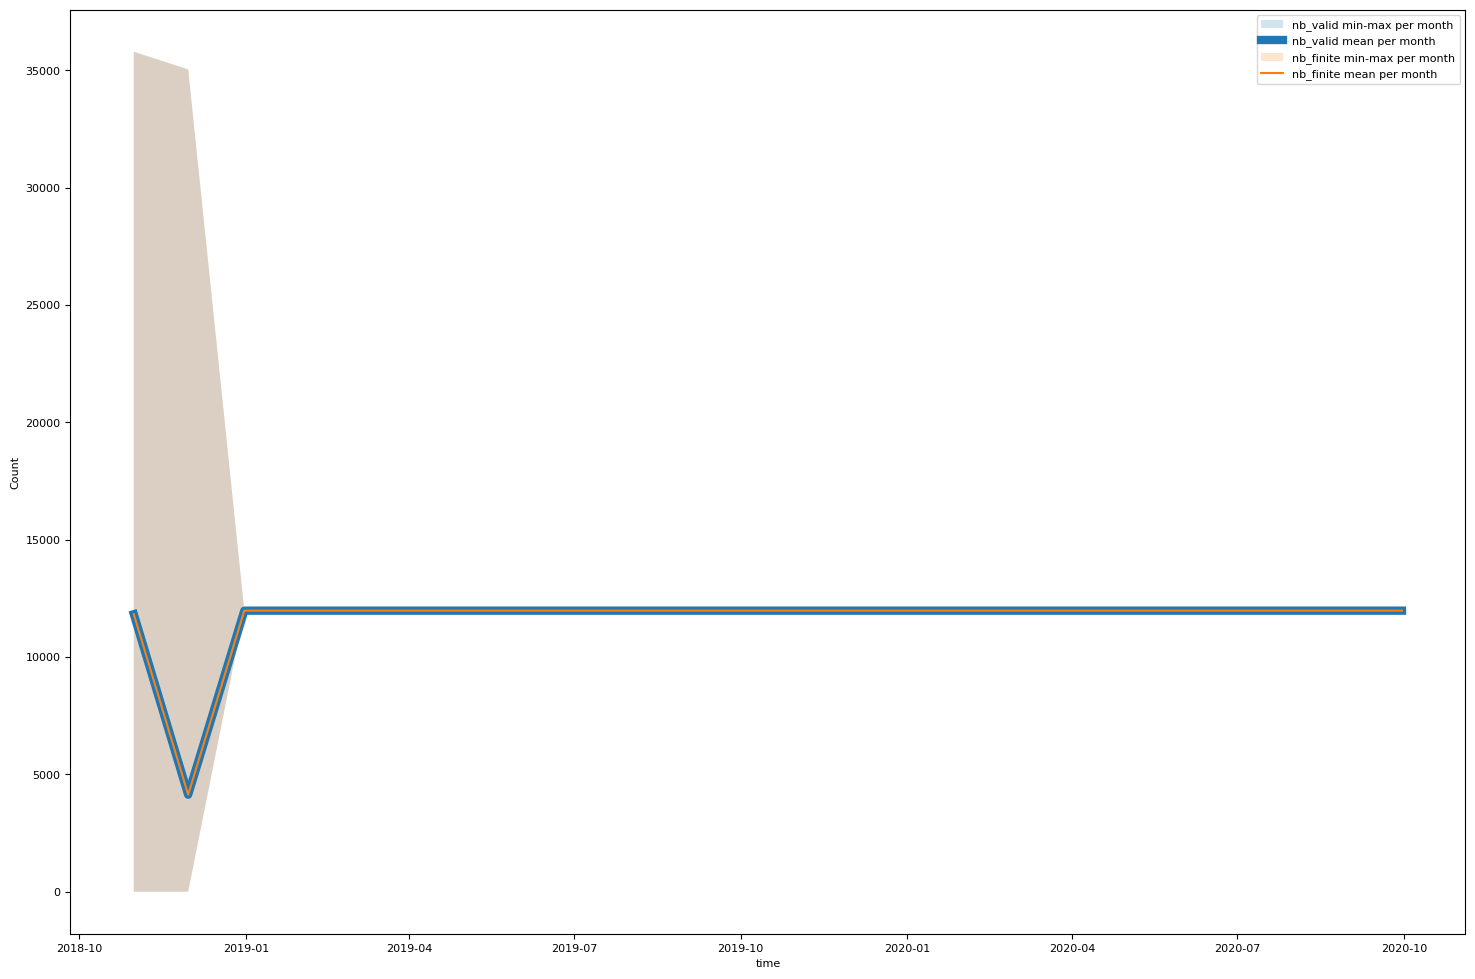

In [111]:
FEED_NB = 2
meta = getMeta(FEED_NB, DATA_DIR)
print(f"Feed Id: {FEED_NB} file start at {datetime.datetime.fromtimestamp(meta["start_time"])}")
print(f"meta: {meta}")
STEP = int(1)
NB_DAYS = int(365 * 2)
DAY_S = 3600 * 24
start = meta["start_time"]
length = meta["npoints"] * meta["interval"]
WINDOW = min(DAY_S, length)

nbpts = WINDOW // STEP
timer_start = time.perf_counter()
stats = []
nb_io_read = 0
for i in range(0, NB_DAYS):
    start_i = start + (DAY_S * i)
    # start_i = int(1727276746 - ((15 * 3600) + (3600 / 2)) + (NB_DAYS * 2))
    data = PyFina(FEED_NB, DATA_DIR, start_i, STEP, nbpts, remove_nan=False)
    data = np.round(data, 3)
    nb_io_read += 1
    nb_valid = (20 < data) & (data < 40)
    stats.append([
        start_i,
        time.perf_counter() - timer_start,
        data.shape[0],
        int(np.isfinite(data).sum()),
        int(np.isnan(data).sum()),
        int(nb_valid.sum()),
        int(np.isinf(data).sum())
    ])

def desc_resampler(arraylike):
    print(arraylike.describe())
    return arraylike

if len(stats) > 0:
    df = pd.DataFrame(stats, columns=['time', 'perf', 'lines', 'nb_finite', 'nb_nan', 'nb_valid', 'nb_inf'])
    df = df.set_index(pd.to_datetime(df['time'], unit='s'))
    df.index.name = 'index'
    print(f"Analysed {NB_DAYS} Days in {time.perf_counter() - timer_start}s -- IO File Reads = {nb_io_read}")
    print("Global stats: ")
    display(df.describe())
    display(df)
    display(df.sort_values('nb_valid')['nb_valid'])
    display(df.sort_values('nb_valid')['nb_valid'].value_counts())
    #print("Year stats: ")
    #print(df.resample('y').apply(desc_resampler))
    nb_valid_d = df['nb_valid'].resample('m').agg(['mean', 'std', 'min', 'max'])
    nb_finite_d = df['nb_finite'].resample('m').agg(['mean', 'std', 'min', 'max'])
    plt.figure(figsize = (18, 12))
    plt.subplot(1, 1, 1)
    plt.ylabel("Count")
    plt.xlabel("time")
    plt.fill_between(nb_valid_d.index, nb_valid_d['max'], nb_valid_d['min'], alpha=0.2, label='nb_valid min-max per month')
    plt.plot(nb_valid_d.index, nb_valid_d['mean'], label='nb_valid mean per month', lw=6)
    plt.fill_between(nb_finite_d.index, nb_finite_d['max'], nb_finite_d['min'], alpha=0.2, label='nb_finite min-max per month')
    plt.plot(nb_finite_d.index, nb_finite_d['mean'], label='nb_finite mean per month')
    plt.legend()
    plt.show()